In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks

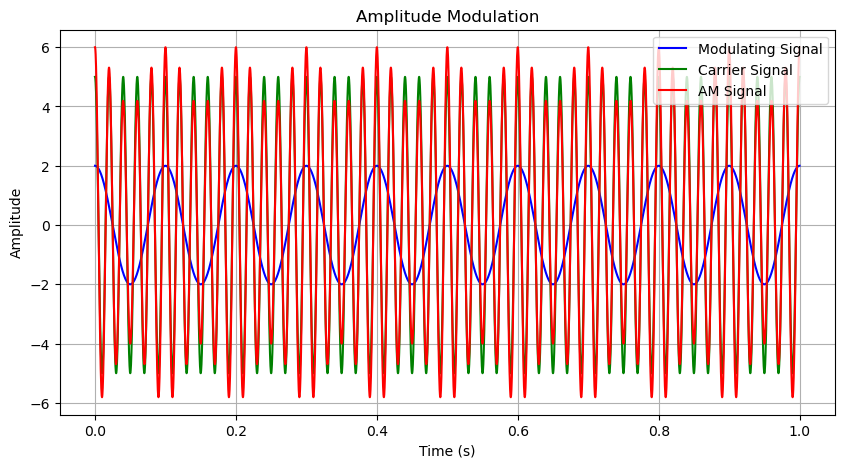

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
fs = 10000  # Sampling frequency (Hz)
fc = 50  # Carrier frequency (Hz)
fm = 10  # Modulating frequency (Hz)
t = np.arange(0, 1, 1/fs)  # Time vector

# --- Modulating signal ---
A = 2.  # Amplitude of the modulating signal
msg = A * np.cos(2 * np.pi * fm * t)

# --- Carrier signal ---
Ac = 5  # Amplitude of the carrier signal
carrier = Ac * np.cos(2 * np.pi * fc * t)

# --- Amplitude Modulation ---
# this is the simulated signal that we want to use
# This is teh QPO signal
am_signal = carrier * (1 + 0.5 * msg / Ac)  # 0.5 is the modulation index

# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.plot(t, msg, label='Modulating Signal', color='blue')
plt.plot(t, carrier, label='Carrier Signal', color='green')
plt.plot(t, am_signal, label='AM Signal', color='red')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude Modulation')
plt.legend()
plt.grid(True)
plt.show()

In [3]:

# --- 1. Simulation Function ---
def simulate_black_hole_lightcurve(fs, fc, fm, qpo_amplitude, duration,
                                   noise_mean=0, noise_std=0.5,
                                   include_qpo=True, modulation_index=0.5):
    """
    Simulate a black hole light curve with stochastic noise and an amplitude-modulated QPO signal.

    Parameters:
        fs : int
            Sampling frequency (Hz)
        fc : float
            Carrier frequency (Hz) for QPO
        fm : float
            Modulating frequency (Hz) for QPO
        qpo_amplitude : float
            Amplitude of the carrier signal (QPO)
        duration : float
            Duration of lightcurve (seconds)
        noise_mean : float
            Mean of the Gaussian noise
        noise_std : float
            Standard deviation of the Gaussian noise
        include_qpo : bool
            Whether to include the QPO signal
        modulation_index : float
            Modulation index for AM signal

    Returns:
        t : np.ndarray
            Time array
        flux : np.ndarray
            Normalized flux array
    """
    # Time array
    t = np.arange(0, duration, 1/fs)

    # White noise
    white_noise = np.random.normal(noise_mean, noise_std, size=len(t))
    white_noise = np.exp(white_noise)

    if include_qpo and qpo_amplitude > 0:
        # Modulating signal
        msg = qpo_amplitude * np.cos(2 * np.pi * fm * t)

        # Carrier signal
        carrier = qpo_amplitude * np.cos(2 * np.pi * fc * t)

        # AM QPO signal
        qpo = carrier * (1 + modulation_index * msg / qpo_amplitude)
    else:
        qpo = 0

    # Combine noise and QPO signal
    flux = white_noise + qpo

    # Normalize
    flux = (flux - np.mean(flux)) / np.std(flux)

    return t, flux

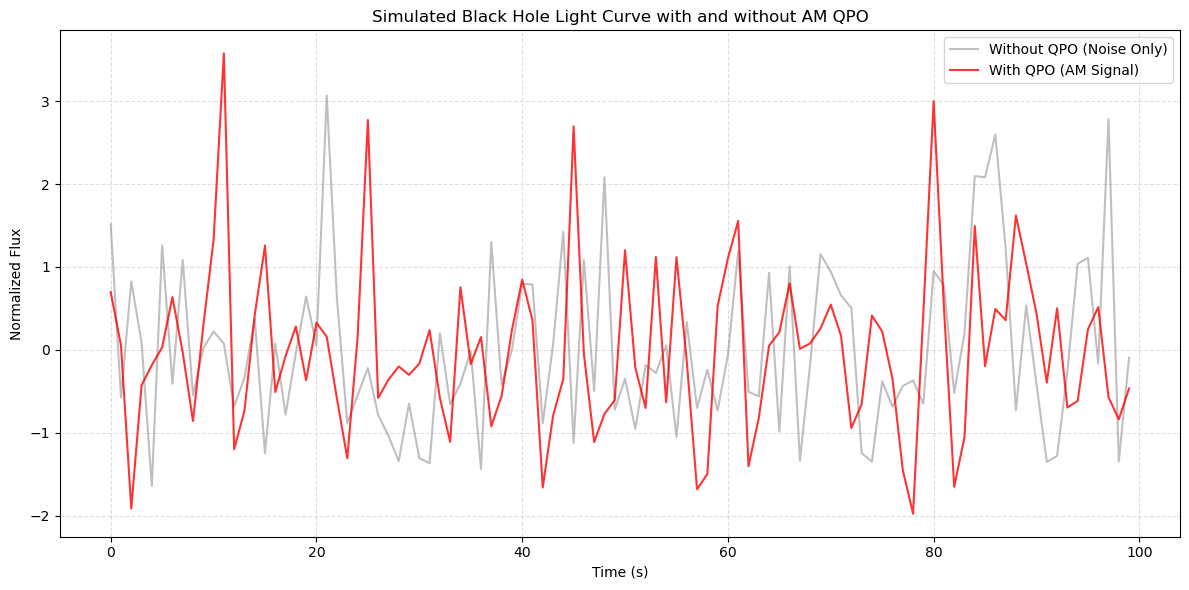

In [4]:
# --- Simulation Parameters ---
fs = 1           # Sampling frequency (Hz)
fc = 0.2             # QPO (carrier) frequency in Hz
fm = 0.05            # Modulating frequency in Hz
duration = 100        # Duration of the signal in seconds
qpo_amplitude = 0.6 # Amplitude of QPO signal

# --- Generate Simulated Light Curves ---
t, flux_with_qpo = simulate_black_hole_lightcurve(
    fs, fc, fm, qpo_amplitude=qpo_amplitude, duration=duration, include_qpo=True)

_, flux_without_qpo = simulate_black_hole_lightcurve(
    fs, fc, fm, qpo_amplitude=qpo_amplitude, duration=duration, include_qpo=False)

# --- Plotting the Time-Domain Light Curve ---
plt.figure(figsize=(12, 6))
plt.plot(t, flux_without_qpo, color='gray', alpha=0.5, label="Without QPO (Noise Only)")
plt.plot(t, flux_with_qpo, color='red', alpha=0.8, label="With QPO (AM Signal)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Flux")
plt.title("Simulated Black Hole Light Curve with and without AM QPO")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


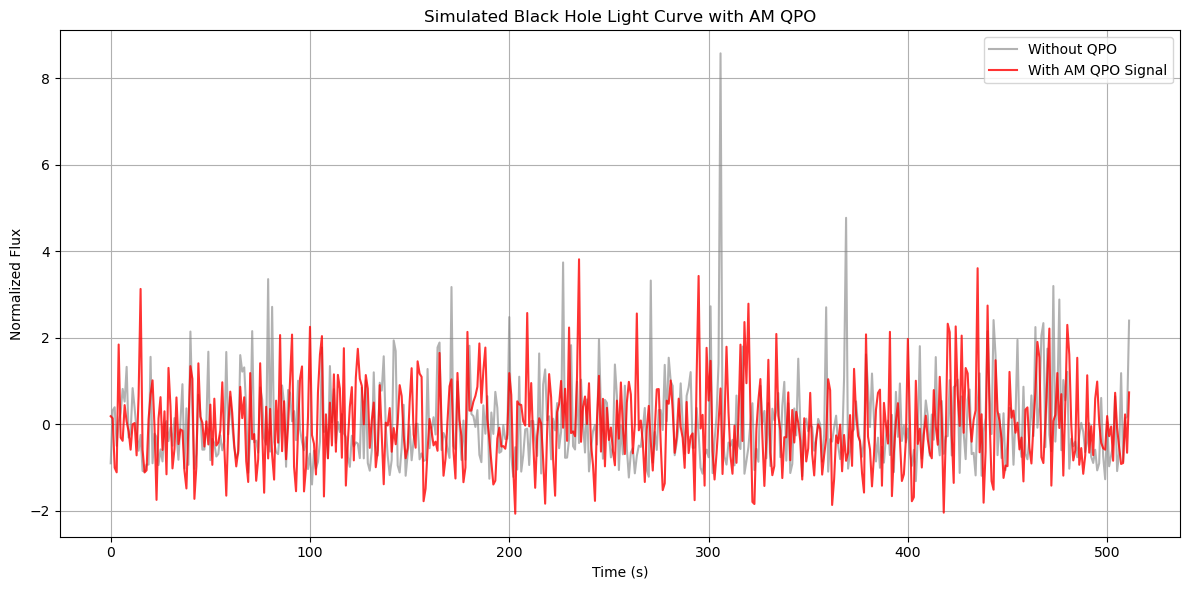

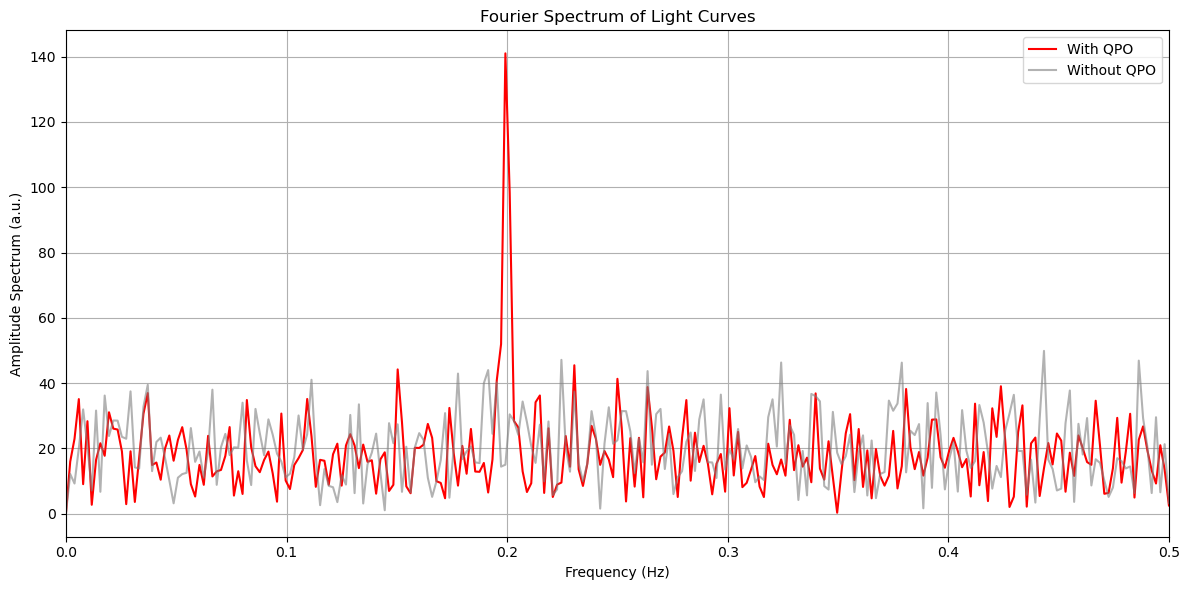

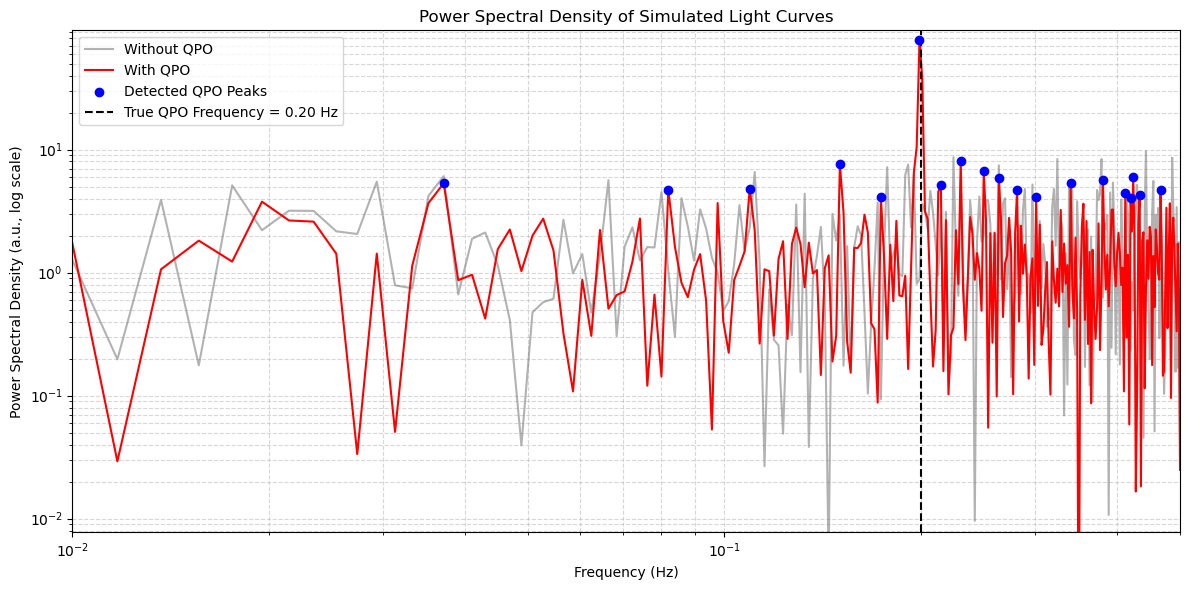

In [5]:
# --- Simulate a QPO and non-QPO light curve ---
fs = 1      # Sampling frequency (Hz)
duration = 512    # Duration in seconds
fc = 0.2         # QPO (carrier) frequency
fm = 0.05        # Modulation frequency
amplitude = 0.4  # QPO signal amplitude

# Generate signals
t, flux_with_qpo = simulate_black_hole_lightcurve(
    fs, fc, fm, amplitude, duration, include_qpo=True)
_, flux_without_qpo = simulate_black_hole_lightcurve(
    fs, fc, fm, amplitude, duration, include_qpo=False)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t, flux_without_qpo, color='gray', alpha=0.6, label="Without QPO")
plt.plot(t, flux_with_qpo, color='red', alpha=0.8, label="With AM QPO Signal")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Flux")
plt.title("Simulated Black Hole Light Curve with AM QPO")
# plt.xlim(0, 2)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Fourier Transform ---
n = len(t)
freqs = np.fft.rfftfreq(n, 1/fs)

fft_qpo = np.abs(np.fft.rfft(flux_with_qpo))
fft_non_qpo = np.abs(np.fft.rfft(flux_without_qpo))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(freqs, fft_qpo, label="With QPO", color='red')
plt.plot(freqs, fft_non_qpo, label="Without QPO", color='gray', alpha=0.6)
plt.xlim(0, 0.5)  # focus on QPO frequency range
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude Spectrum (a.u.)")
plt.title("Fourier Spectrum of Light Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

N = len(flux_with_qpo)

# Periodogram (Power Spectrum)
periodogram_with_qpo = (2.0 / N) * np.abs(fft_qpo)**2
periodogram_without_qpo = (2.0 / N) * np.abs(fft_non_qpo)**2

# --- Peak Detection ---
peaks, _ = find_peaks(periodogram_with_qpo,
                      height=np.mean(periodogram_with_qpo)*2)

# --- Plot Periodogram with Detected Peaks ---
plt.figure(figsize=(12, 6))
plt.plot(freqs, periodogram_without_qpo,
         color='gray', alpha=0.6, label="Without QPO")
plt.plot(freqs, periodogram_with_qpo, color='red', label="With QPO")
plt.scatter(freqs[peaks], periodogram_with_qpo[peaks],
            color='blue', zorder=5, label="Detected QPO Peaks")
plt.axvline(fc, color='black', linestyle='--',
            label=f"True QPO Frequency = {fc:.2f} Hz")

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01, 0.5)
max_power = np.max(periodogram_with_qpo)
plt.ylim(max_power * 1e-4, max_power * 1.2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (a.u., log scale)")
plt.title("Power Spectral Density of Simulated Light Curves")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf


def verify_qpo_simulation(t, flux, qpo_freq_expected=None, fs=1.0):
    """
    Verify the presence of a QPO in a simulated light curve using:
    1. Fourier Power Spectrum (rFFT-based Periodogram)
    2. Autocorrelation Function (ACF)

    Parameters:
    - t: Time array
    - flux: Simulated light curve
    - qpo_freq_expected: Expected QPO frequency for reference (optional)
    - fs: Sampling frequency (Hz)
    """
    N = len(flux)
    T = 1.0 / fs

    # rFFT and frequency axis
    fft_vals = np.fft.rfft(flux)
    freqs = np.fft.rfftfreq(N, T)

    # Periodogram (PSD)
    power = (2.0 / N) * np.abs(fft_vals)**2

    # Detect peaks in PSD
    peaks, props = find_peaks(power, height=np.mean(power) * 2)

    # Autocorrelation Function
    lag_values = np.arange(0, 200)
    acf_vals = acf(flux, nlags=199, fft=True)

    # --- Plot PSD and ACF ---
    plt.figure(figsize=(12, 6))

    # PSD
    plt.subplot(2, 1, 1)
    plt.plot(freqs, power, label="Power Spectrum", color='darkblue')
    plt.scatter(freqs[peaks], power[peaks],
                color='red', label="Detected Peaks")
    if qpo_freq_expected:
        plt.axvline(qpo_freq_expected, linestyle='--', color='black',
                    label=f"Expected QPO = {qpo_freq_expected:.2f} Hz")

    plt.xscale("log")
    plt.yscale("log")
    max_power = np.max(power)
    plt.ylim(max_power * 1e-4, max_power * 1.2)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (log scale)")
    plt.title("Fourier Periodogram for QPO Detection")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()

    # ACF
    plt.subplot(2, 1, 2)
    plt.plot(lag_values, acf_vals, color='green', label="ACF")
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Lag (Time Steps)")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation Function (ACF) of Light Curve")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Print Summary ---
    print("🔍 Detected QPO frequency peaks (Hz):", freqs[peaks])

    if qpo_freq_expected:
        close_peaks = [f for f in freqs[peaks]
                       if np.isclose(f, qpo_freq_expected, atol=0.02)]
        if close_peaks:
            print(
                f"✔ QPO detected near {qpo_freq_expected:.2f} Hz:", close_peaks)
        else:
            print(
                f"❌ No significant QPO detected near {qpo_freq_expected:.2f} Hz.")

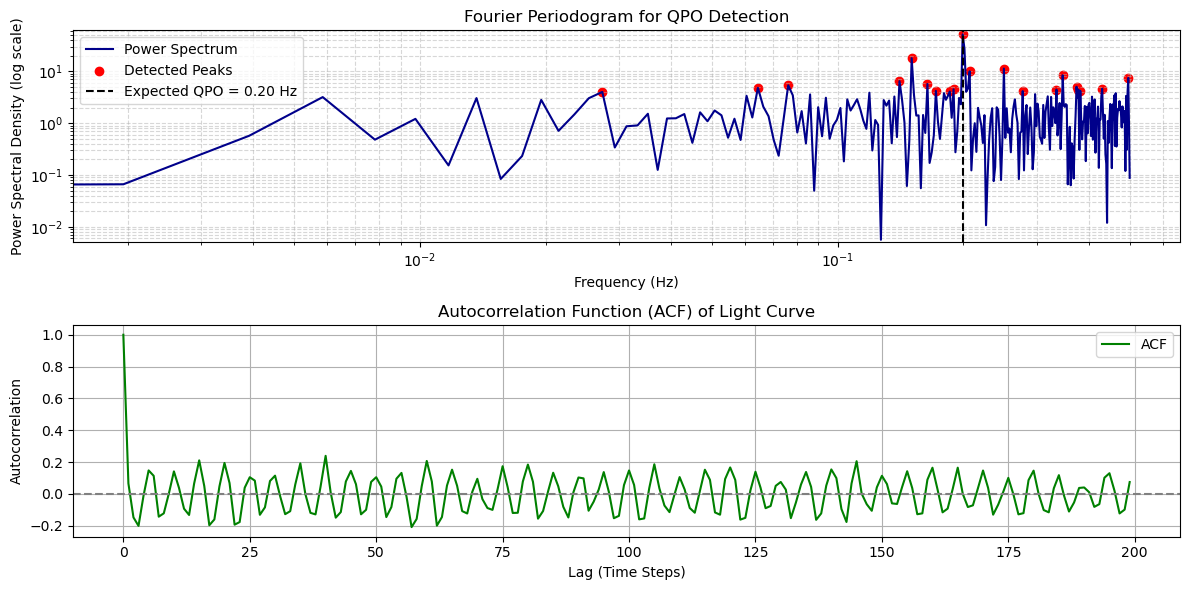

🔍 Detected QPO frequency peaks (Hz): [0.02734375 0.06445312 0.07617188 0.140625   0.15039062 0.1640625
 0.171875   0.18554688 0.18945312 0.19921875 0.20703125 0.25
 0.27734375 0.33398438 0.34570312 0.37304688 0.37695312 0.38085938
 0.4296875  0.49609375]
✔ QPO detected near 0.20 Hz: [0.185546875, 0.189453125, 0.19921875, 0.20703125]


In [9]:
# Simulate light curve with QPO
fs = 1
duration = 512
fc = 0.2  # QPO frequency
fm = 0.05
amplitude = 0.4

t, flux_with_qpo = simulate_black_hole_lightcurve(fs, fc, fm, amplitude, duration, include_qpo=True)

# Verify QPO presence
verify_qpo_simulation(t, flux_with_qpo, qpo_freq_expected=fc, fs=fs)


Dataset shape: (5000, 512, 1)
Labels shape: (5000, 2)


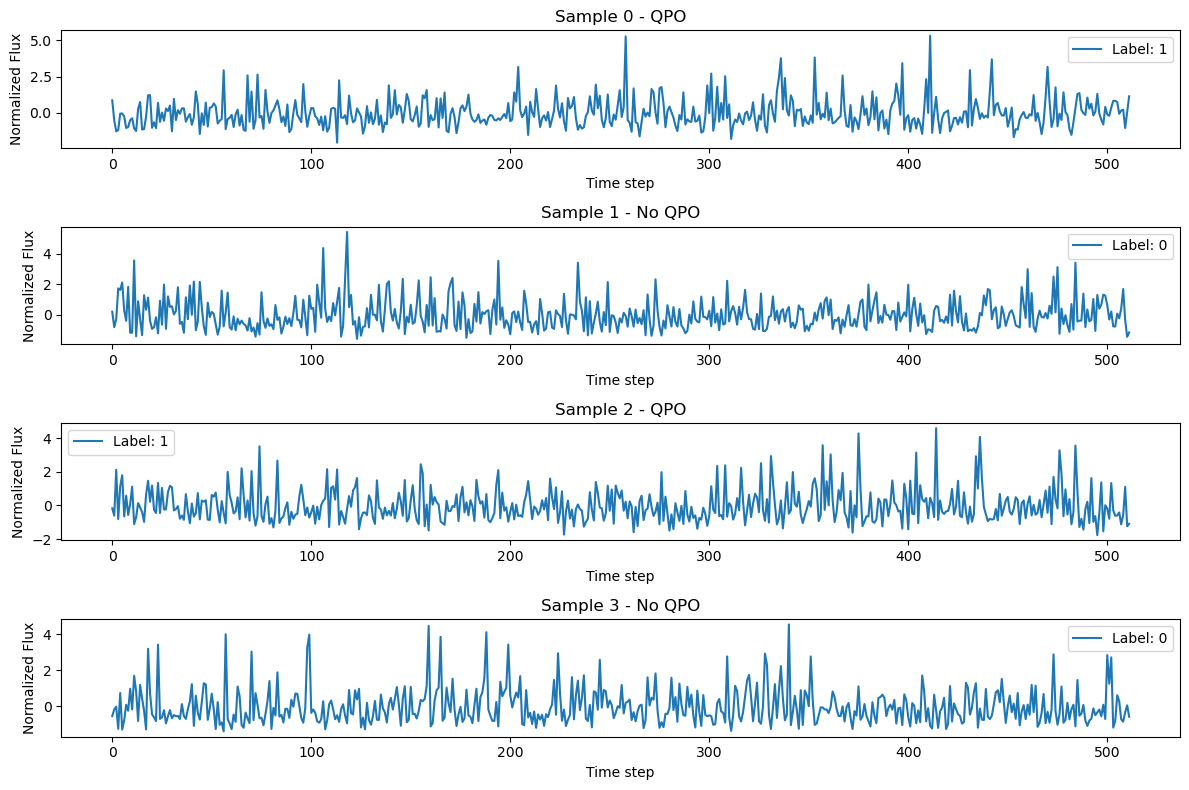

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Load your .npz file
data = np.load('qpo_experiments/dataset_amp_0.2/data.npz')
X = data['X']  # Shape: (samples, time_steps, 1)
y = data['y']  # Shape: (samples, 2)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

# Plot a few samples
num_samples_to_plot = 4

plt.figure(figsize=(12, 8))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(X[i].squeeze(), label=f"Label: {np.argmax(y[i])}")
    plt.title(f"Sample {i} - {'QPO' if np.argmax(y[i]) == 1 else 'No QPO'}")
    plt.xlabel("Time step")
    plt.ylabel("Normalized Flux")
    plt.legend()
    plt.tight_layout()

plt.show()
